In [ ]:
import pandas as pd

in_data_file = "imputed_labeled_MMA_data_1.csv"
multiclass_data_file = f"multiclass_{in_data_file}"

df = pd.read_csv(in_data_file)  

# Ensure labels are strings or integers, convert if necessary
df["Vitamin_B12_Problem_Label"] = df["Vitamin_B12_Problem_Label"].astype(str)
df["Kidney_problem"] = df["Kidney_problem"].astype(str)

# Define a function to assign multiclass labels
def assign_multiclass_label(row):
    b12 = row["Vitamin_B12_Problem_Label"]
    kidney = row["Kidney_problem"]
    
    if b12 == '1' and kidney == '0':
        return 0  # No problem
    elif b12 == '0' and kidney == '0':
        return 1  # B12 problem only
    elif b12 == '1' and kidney == '1':
        return 2  # Kidney problem only
    elif b12 == '0' and kidney == '1':
        return 3  # Both problems

# Apply the function to create a new column
df["MMA_Etiology_Class"] = df.apply(assign_multiclass_label, axis=1)

# Optional: check distribution
print(df["MMA_Etiology_Class"].value_counts())

# Save the new dataset
df.to_csv(multiclass_data_file, index=False)


In [ ]:
#pip install pandas xgboost scikit-learn

In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

df = pd.read_csv(multiclass_data_file)

columns_to_drop = [
    "Vitamin_B12_Problem_Label", 
    "Kidney_problem"
]
df.drop(columns=columns_to_drop, inplace=True)

if df['Gender'].dtype == 'object':
    le = LabelEncoder()
    df['Gender'] = le.fit_transform(df['Gender']) 

X = df.drop("MMA_Etiology_Class", axis=1)
y = df["MMA_Etiology_Class"]

# Optional: Standardize numerical features (for logistic regression, SVM, etc.)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Confirm shapes
print("Feature matrix shape:", X_scaled.shape)
print("Target distribution:\n", y.value_counts())

# Save for modeling
X_scaled.to_csv("X_mma_scaled.csv", index=False)
y.to_csv("y_mma_multiclass.csv", index=False)


Full dataset class distribution:
 MMA_Etiology_Class
1    12399
3     1853
Name: count, dtype: int64
Training set class distribution:
 MMA_Etiology_Class
0    9919
1    1482
Name: count, dtype: int64
Test set class distribution:
 MMA_Etiology_Class
0    2480
1     371
Name: count, dtype: int64

🔹 Logistic Regression Results
Accuracy: 0.9968432129077517
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2480
           1       0.99      0.98      0.99       371

    accuracy                           1.00      2851
   macro avg       0.99      0.99      0.99      2851
weighted avg       1.00      1.00      1.00      2851



/Users/galactica/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1254: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/galactica/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [16:15:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



🔹 XGBoost Results
Accuracy: 0.9978954752718344
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2480
           1       0.99      0.99      0.99       371

    accuracy                           1.00      2851
   macro avg       1.00      0.99      1.00      2851
weighted avg       1.00      1.00      1.00      2851



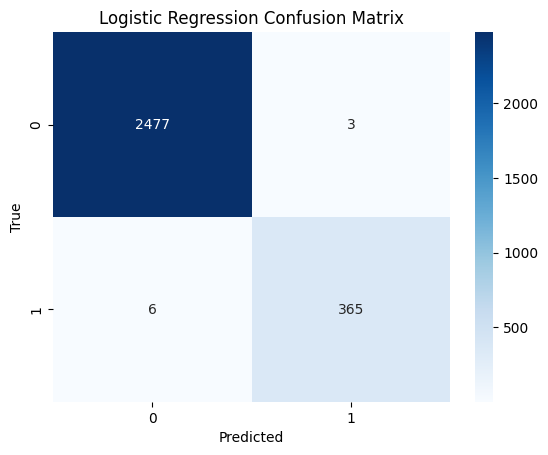

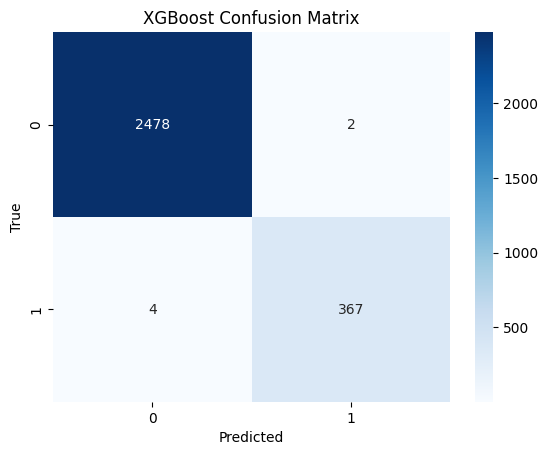

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load processed features and labels
X = pd.read_csv("X_mma_scaled.csv")
y = pd.read_csv("y_mma_multiclass.csv").squeeze()  # ensure it's a Series

# Print class distribution
print("Full dataset class distribution:\n", y.value_counts())

# Encode y labels to be consecutive integers
label_map = {label: idx for idx, label in enumerate(sorted(y.unique()))}
inv_label_map = {v: k for k, v in label_map.items()}  # for reverse decoding later
y_encoded = y.map(label_map)

# Stratified train-test split
X_train, X_test, y_train_enc, y_test_enc = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

# Confirm all classes are in training
print("Training set class distribution:\n", y_train_enc.value_counts())
print("Test set class distribution:\n", y_test_enc.value_counts())
# -------------------------------
# 1. Logistic Regression
# -------------------------------
log_reg = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
log_reg.fit(X_train, y_train_enc)
y_pred_logreg = log_reg.predict(X_test)

print("\n🔹 Logistic Regression Results")
print("Accuracy:", accuracy_score(y_test_enc, y_pred_logreg))
print(classification_report(y_test_enc, y_pred_logreg))

# -------------------------------
# 2. XGBoost Classifier (Fixed)
# -------------------------------

xgb = XGBClassifier(
    objective='multi:softprob',
    num_class=len(label_map),
    eval_metric='mlogloss',
    use_label_encoder=False
)
xgb.fit(X_train, y_train_enc)
y_pred_probs = xgb.predict(X_test)  # this gives a 2D array
y_pred_xgb = np.argmax(y_pred_probs, axis=1)


print("\n🔹 XGBoost Results")
print("Accuracy:", accuracy_score(y_test_enc, y_pred_xgb))
print(classification_report(y_test_enc, y_pred_xgb))

# -------------------------------
# Confusion Matrices
# -------------------------------
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

plot_confusion(y_test_enc, y_pred_logreg, "Logistic Regression Confusion Matrix")
plot_confusion(y_test_enc, y_pred_xgb, "XGBoost Confusion Matrix")


/var/folders/5f/7zn60cf53sxc74yn0mv8wdf80000gn/T/ipykernel_14735/1917009944.py:22: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/galactica/miniconda3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


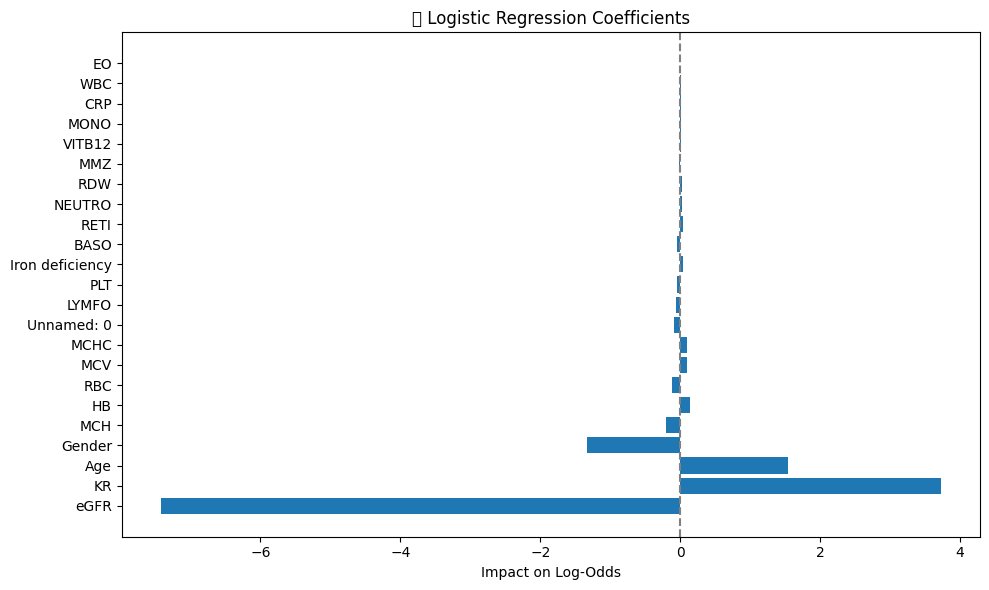

/var/folders/5f/7zn60cf53sxc74yn0mv8wdf80000gn/T/ipykernel_14735/1917009944.py:39: UserWarning: Glyph 127794 (\N{EVERGREEN TREE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/galactica/miniconda3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127794 (\N{EVERGREEN TREE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


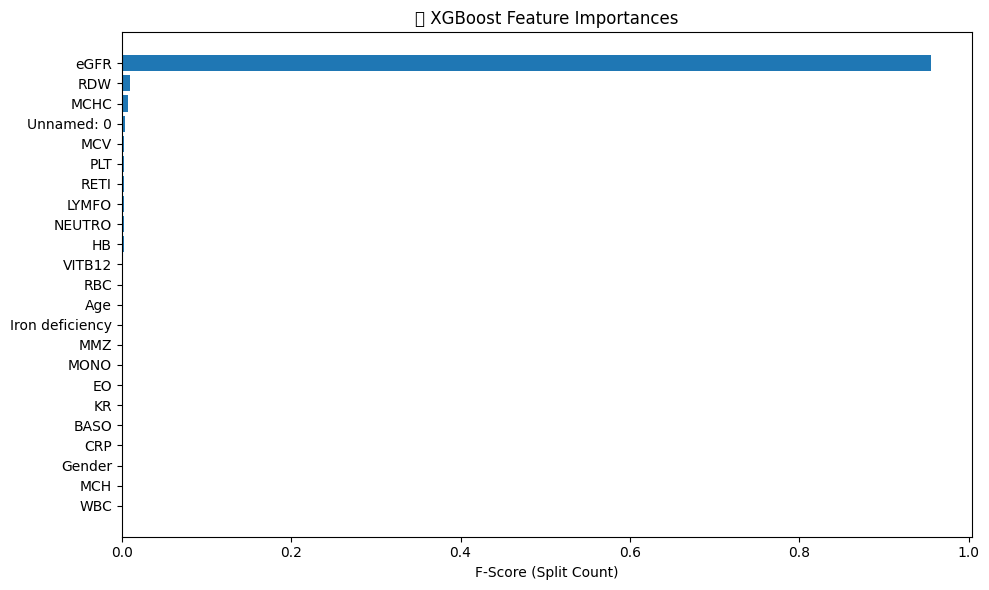

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------
# 1. Logistic Regression Coefficients
# -------------------------------------
coef = log_reg.coef_[0]
features = X.columns

# Create DataFrame
coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': coef
}).sort_values(by='Coefficient', key=abs, ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(coef_df['Feature'], coef_df['Coefficient'])
plt.title('🔍 Logistic Regression Coefficients')
plt.xlabel('Impact on Log-Odds')
plt.axvline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

# -------------------------------------
# 2. XGBoost Feature Importances
# -------------------------------------
importances = xgb.feature_importances_
xgb_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=True)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(xgb_df['Feature'], xgb_df['Importance'])
plt.title('🌲 XGBoost Feature Importances')
plt.xlabel('F-Score (Split Count)')
plt.tight_layout()
plt.show()
